In [1]:
import os
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## MNIST example (quickstart)

In [ ]:
# MNIST example from TensorFlow tutorials
mnist = keras.datasets.mnist

# Load and scale data
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = mnist.load_data()
mnist_train_x, mnist_test_x = mnist_train_x / 255.0, mnist_test_x / 255.0

# Creat simple NN
mnist_model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(10)
])

# Loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile model
mnist_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=['accuracy'])

# Fit model
mnist_history = mnist_model.fit(mnist_train_x, mnist_train_y, epochs=4, verbose=1)

# Test model 
mnist_model.evaluate(mnist_test_x, mnist_test_y)

## MPG example (regression)

In [ ]:
# MPG example from TensorFlow tutorials

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Load dataset, remove rows with missing info
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True).dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Convert Origin to one-hot
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

# Split train/test and split labels
mpg_train_x = dataset.sample(frac=0.8, random_state=0)
mpg_test_x = dataset.drop(mpg_train_x.index)
mpg_train_y = mpg_train_x.pop('MPG')
mpg_test_y = mpg_test_x.pop('MPG')

# Scale data
mpg_norm = keras.layers.Normalization(axis=-1)
mpg_norm.adapt(np.array(mpg_train_x))

# Build model
def build_and_compile_model(normalization):
  model = keras.Sequential([
      normalization,
      keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
      keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=keras.optimizers.Adam())
  return model

mpg_model = build_and_compile_model(mpg_norm)

# Early stopping
callbacks = [
  keras.callbacks.EarlyStopping(monitor='val_loss', patience=30),
]
mpg_model_history = mpg_model.fit(mpg_train_x, mpg_train_y, validation_split=0.1, epochs=1000, callbacks=callbacks, verbose=0)
mpg_model.evaluate(mpg_test_x, mpg_test_y, verbose=2)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(mpg_model_history)

## Fashion MNIST example (images)

In [ ]:
# Fashion MNIST example TensorFlow tutorials

# Load dataset
(fashion_train_x, fashion_train_label), (fashion_test_x, fashion_test_label) = keras.datasets.fashion_mnist.load_data()

fashion_train_x = fashion_train_x.astype('float32') / 255.0
fashion_test_x = fashion_test_x.astype('float32') / 255.0

print(f'Total train set length: {len(fashion_train_label)}')
# Create a dataset and batch into 1000 
fashion_dataset = tf.data.Dataset.from_tensor_slices((fashion_train_x, fashion_train_label))
fashion_dataset = fashion_dataset.batch(100, drop_remainder=True)

In [ ]:
class FashionHyperModel(kt.HyperModel):
    def build(self, hyperparameters):
        # Build model architecture
        model = keras.Sequential()
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(
            hyperparameters.Choice('units', values=[32, 64, 128, 256, 512]), 
            activation='relu'))
        model.add(keras.layers.Dense(10))

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(
                hyperparameters.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# Create tuner
tuner = kt.Hyperband(FashionHyperModel(),
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='models',
                     project_name='fashion_tutorial',
                     factor=3)

tuner.reload()

In [ ]:
# Tuning hyperparameters. Does not need to run again if model is saved under models/fashion_tutorial

# Early stopping criterion
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

tuner.search(fashion_train_x, fashion_train_label, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Optimal number of units in first Dense() layer is {best_hps.get("units")}')
print(f'Optimal learning rate for the optimizer is {best_hps.get("learning_rate")}')

# Retrain the model with best hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(fashion_train_x, fashion_train_label, epochs=10, validation_split=0.2)

# Evaluate on test data
eval_result = hypermodel.evaluate(fashion_test_x, fashion_test_label)
print("[test loss, test accuracy]:", eval_result)

## CIFAR10 example (CNN)

In [2]:
# Load CIFAR10
(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
cifar_train_images, cifar_test_images = cifar_train_images / 255.0, cifar_test_images / 255.0

In [14]:
cifar_model = keras.models.Sequential([
    # Input layer indicates image size as height, width, channels (here we have RGB)
    keras.layers.InputLayer((32,32,3)),
    # Data augmentation layers
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    # Series of convolutional levels with pooling
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Layers get deeper (more filters), but with smaller 2D matrices in each
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    # Dropout layer to fight overfitting
    keras.layers.Dropout(0.3),
    # Flatten at the end to predict final labels
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

cifar_model.summary()

cifar_model.compile(optimizer=keras.optimizers.Nadam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cifar_callbacks = [
    # Early stopping   
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
]

cifar_history = cifar_model.fit(
    cifar_train_images, cifar_train_labels, 
    epochs=30, batch_size=64, verbose=2,
    validation_data=(cifar_test_images, cifar_test_labels))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 64)       

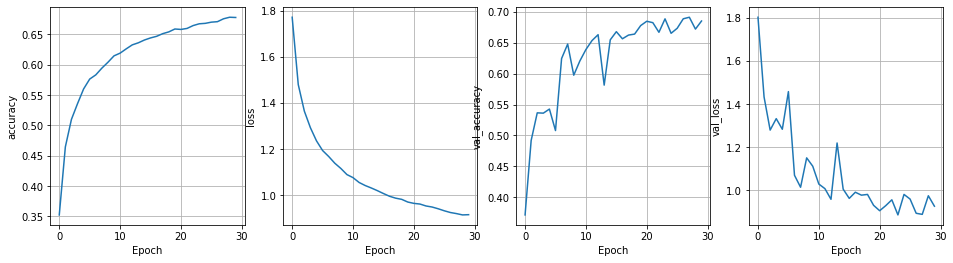

In [15]:
def plot_model_history(history, labels=[]):
    label_count = len(labels)
    if label_count > 0:
        fig, axes = plt.subplots(1, label_count, figsize=(4*label_count, 4))
        for axis, label in zip(axes, labels):
            axis.plot(history.history[label], label=label)
            axis.set_xlabel('Epoch')
            axis.set_ylabel(label)
            axis.grid(True)

plot_model_history(cifar_history, ['accuracy', 'loss', 'val_accuracy', 'val_loss'])
